# Mustererkennung Übung 4
Samuel Gfrörer <br>
Marcel Schmidt <br>

In [15]:
import numpy as np
import random as rn
import pylab
from numpy.linalg import pinv
from numpy.linalg import norm
from sklearn.cross_validation import train_test_split

def getData():
    file = open("res/spambase.data", "r") 
    Data=[]    
    for line in file:
        floatLine = []
        tmpLine = line.split(',')
        Linelen = len(tmpLine)            
        for i in range(0,Linelen):
            floatLine.append(float(tmpLine[i]))            
        Data.append(floatLine)                
    file.closed   
    return Data

def getVectors(label, data):
    vectors = []
    for line in data:
        #print(line[-1])
        if(line[-1] == float(label)):
            vectors.append(line[:-1])
    return np.array(vectors)

## Hilfsfunktionen

- MittelPunktVector(VecList): Berechnung des Mittelpunktvektors aus einer Liste von Vektoren $\vec v_0$ bis $\vec v_N$  
  
$$\vec M = \frac{1}{N} \sum_{i = 0}^N \vec v_i $$  
  
- getKovarianzMatrix(Data, M): Berechnung der Kovarianzmatrix $\Sigma$ aus einer Liste von Vektoren $\vec v_0$ bis $\vec v_N$ und zugehörigem Mittelpunktvektor $\vec M$  
  
$$\Sigma = \frac{1}{N}\sum_{i = 0}^N (\vec v_i - \vec M)(\vec v_i - \vec M)^T $$  
  
- gauß(x, mean, var): Berechnung der Wahrscheinlichkeitsdichte p(x) für Mittelwert $\mu$ und Varianz $\sigma^2$ mit gaußscher Normalverteilung  
  
$$p(x) = \frac{1}{ \sqrt{2  \pi \sigma^2} } e^{-\frac{(x - \mu)^2}{2 \sigma^2}} $$

In [16]:
def MittelPunktVector(VecList):    
    M = np.array(VecList[0])
    n = len(VecList)    
    for i in range(1,n):
        tmpVec = np.array(VecList[i])
        M = M + tmpVec
    M = M / (n) 
    return M

def getKovarianzMatrix(Data, M):  
    n = len(Data)    
    x = np.matrix(Data[0])
    X = np.transpose((x - M)) @ (x - M)   
    for i in range(1,n):        
        x = np.matrix(Data[i])
        tmpX = np.transpose((x - M)) @ (x - M)        
        X = X + tmpX        

    return (X / n)

def gauß(x, mean, var):
    return (1 / np.sqrt(2 * np.pi * var )) * np.exp( -((x - mean)**2/(2 * var)))

## Berechnung von Projektionsvektor alpha, Mittelwert und Varianz

- Einlesen der Vektoren
- Aufteilen in positive und negative Klassen
- Zufälliges Aufspalten in 20% Testdaten und 80% Trainingsdaten

In [17]:
data = getData()

TrainVecsP = getVectors(1, data)
TrainVecsN = getVectors(0, data)

TrainVecsP ,TestVecsP = train_test_split(TrainVecsP,test_size=0.2)
TrainVecsN ,TestVecsN = train_test_split(TrainVecsN,test_size=0.2)


- Berechnung der Mittelpunktsvektoren und Kovarianzmatrizen für P und N

In [18]:
mu_p = MittelPunktVector(TrainVecsP)
mu_n = MittelPunktVector(TrainVecsN)

kov_p = getKovarianzMatrix(TrainVecsP, mu_p)
kov_n = getKovarianzMatrix(TrainVecsN, mu_n)


- Berechnung von alpha mit den Kovarianzmatrizen $\Sigma_P$, $\Sigma_N$ und den Mittelpunktvektoren $\vec \mu_P$, $\vec \mu_N$ (c = 1, da $\vec \alpha$ danach auf Länge 1 normiert wird und Skalierung damit egal )  
  
$$ \vec \alpha = c (\Sigma_P + \Sigma_N)^{-1} (\vec \mu_P - \vec \mu_N) $$

- Berechnung der Varianzen $\sigma^2$ für P und N  
  
$$ \sigma^2 = \vec \alpha^T \Sigma  \vec \alpha $$
  
- Berechnung des projizierten Mittelwerts $\mu_p$  
  
$$ \mu_p = \vec \mu \cdot \vec \alpha  $$

In [19]:
alpha = pinv((kov_p + kov_n)) @ np.transpose(mu_p - mu_n)
alpha = alpha/norm(alpha)
alpha = np.transpose(alpha)

var_p = float(np.transpose(alpha) @ kov_p @ alpha)
var_n = float(np.transpose(alpha) @ kov_n @ alpha)

mu_p_projected = float(np.dot(mu_p,alpha))
mu_n_projected = float(np.dot(mu_n,alpha))

## Plotten der beiden Dichtefunktionen

Klasse P
Mittelwert: 0.9211686660893882
Varianz: 0.23427130131109436

Klasse N
Mittelwert: -0.14349651064991006
Varianz: 0.19846298316671493


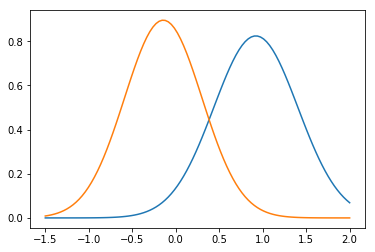

In [20]:
print("Klasse P")
print("Mittelwert: " + str(mu_p_projected))
print("Varianz: " + str(var_p))
print("")
print("Klasse N")
print("Mittelwert: " + str(mu_n_projected))
print("Varianz: " + str(var_n))



x = np.linspace(-1.5,2,100)
y = gauß(x, mu_p_projected, var_p)
pylab.plot(x,y)


x = np.linspace(-1.5,2,100)
y = gauß(x, mu_n_projected, var_n)
pylab.plot(x,y)

pylab.show()

## Projizierung und Klassifizierung der Testdaten

In [21]:
success = 0
tests = len(TestVecsP) + len(TestVecsN)

konfmat = [[0,0],[0,0]]


for vector in TestVecsP:
    proj_vector = float(np.dot(vector,alpha))
    prob_p = gauß(proj_vector, mu_p_projected, var_p)
    prob_n = gauß(proj_vector, mu_n_projected, var_n)
    if(prob_p > prob_n):
        success += 1
        konfmat[0][0] += 1
    else:
        konfmat[0][1] += 1

for vector in TestVecsN:
    proj_vector = float(np.dot(vector,alpha))
    prob_p = gauß(proj_vector, mu_p_projected, var_p)
    prob_n = gauß(proj_vector, mu_n_projected, var_n)
    if(prob_n > prob_p):
        success += 1
        konfmat[1][1] += 1
    else:
        konfmat[1][0] += 1

print("Tests: " + str(tests) + " Erfolge: " + str(success) + " Erfolgsrate: " + str(success/tests))
print()
print("Konfusionsmatrix: ")
print(np.matrix(konfmat))

Tests: 921 Erfolge: 834 Erfolgsrate: 0.9055374592833876

Konfusionsmatrix: 
[[321  42]
 [ 45 513]]
